# Aug 8-9, 2023: trials on fitting SINDy on stimulus signal

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#HIDE
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
import pandas as pd
import pysindy as ps
import sklearn as skl
import sympy
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from scipy import stats, integrate
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# folders
sys.path.insert(0, proj_dir)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

(CVXPY) Aug 09 01:18:27 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 09 01:18:27 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [3]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## dataset

,Hemi,ROI,Index,Voxels,File_Name
49,R,ant. dorsal Insula,50,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz


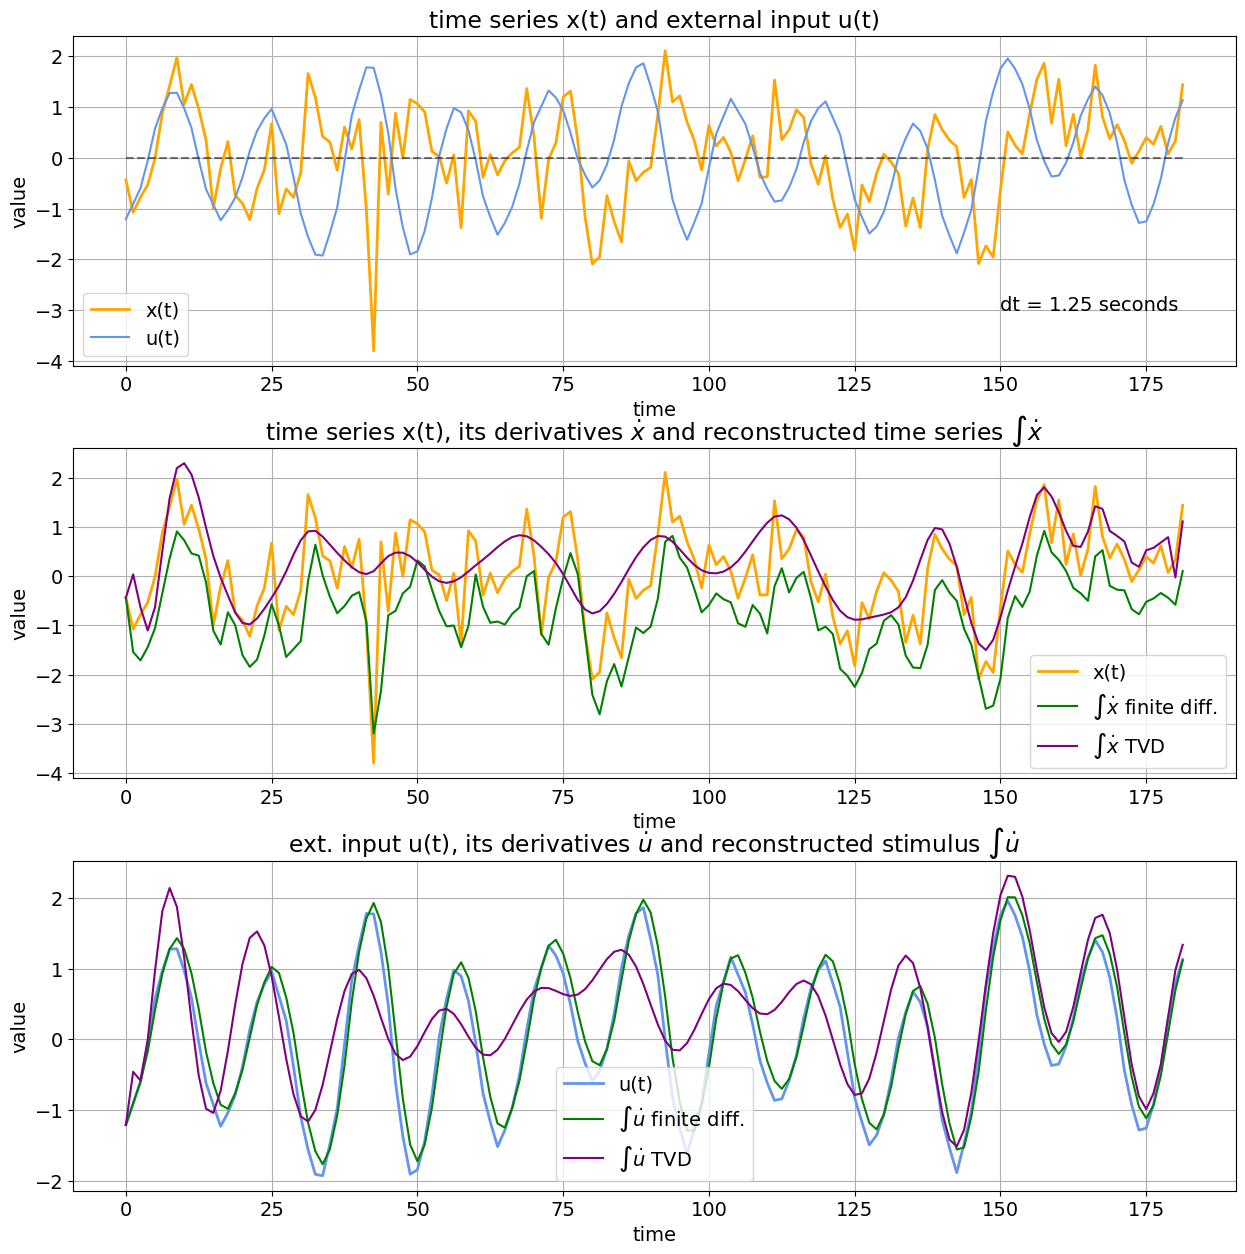

In [4]:
emoprox_dir = pjoin(os.environ['HOME'], 'emoprox_inventory_govinda/emoprox_extract_timeseries')

# ROI atlas/parcellation
atlas_df = pd.read_csv(f"{emoprox_dir}/masks/README_MAX_ROIs_final_gm_85.txt", delimiter='\t')
# display(atlas_df)

roi = 'dorsal Insula'
roi_idx = np.where(atlas_df['Hemi'].str.contains('R') * atlas_df['ROI'].str.contains(roi))[0]
display(atlas_df.iloc[roi_idx])

# data
data_df = pd.read_pickle(f"{emoprox_dir}/dataframes/MAX_ROIs.pkl")

# for idx, row in data_df.iterrows():
    # row['proximity'] = row['proximity'] * row['censor'][:, 0]
    # row['proximity_hrf'] = row['proximity_hrf'] * row['censor'][:, 0]
    # data_df.iloc[idx] = row
data_df['proximity'] = data_df['proximity'].apply(lambda prox: sp.stats.zscore(prox))

df = data_df[data_df['pid'] == '001'][data_df['block'] == 1]
df = df.reset_index()

x = df.iloc[0]['timeseries'][:, roi_idx]
time = df.iloc[0]['time']
dt = time[1]-time[0]

# derivatives $\dot{x}$
# diff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)
xdiff = ps.SmoothedFiniteDifference()._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
prox = df.iloc[0]['proximity'][:, None]

# basic plot check
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.25
)

ax = axs[0]
ax.plot(time, x, c='orange', linestyle='-', label='x(t)', **plot_kws)
ax.plot(time, prox, c='cornflowerblue', linestyle='-', label='u(t)')
ax.plot(time, 0*time, c='black', linestyle='--', alpha=0.5)
ax.text(150, -3, 'dt = 1.25 seconds')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('time series x(t) and external input u(t)')
ax.legend()

ax = axs[1]
ax.plot(time, x, c='orange', linestyle='-', label='x(t)', **plot_kws)
xdiff = ps.FiniteDifference()._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
ax.plot(time, x_, c='green', linestyle='-', label='$\int{\dot{x}}$ finite diff.')
xdiff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
ax.plot(time, x_, c='purple', linestyle='-', label='$\int{\dot{x}}$ TVD')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('time series x(t), its derivatives $\dot{x}$ and reconstructed time series $\int{\dot{x}}$')
ax.legend()

ax = axs[2]
ax.plot(time, prox, c='cornflowerblue', linestyle='-', label='u(t)', **plot_kws)
udiff = ps.FiniteDifference()._differentiate(prox, time)
u_ = np.concatenate([prox[0], prox[0] + np.cumsum(udiff)[:-1]*dt])
ax.plot(time, u_, c='green', linestyle='-', label='$\int{\dot{u}}$ finite diff.')
udiff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)._differentiate(prox, time)
u_ = np.concatenate([prox[0], prox[0] + np.cumsum(udiff)[:-1]*dt])
ax.plot(time, u_, c='purple', linestyle='-', label='$\int{\dot{u}}$ TVD')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('ext. input u(t), its derivatives $\dot{u}$ and reconstructed stimulus $\int{\dot{u}}$')
ax.legend()

## SINDy on fMRI signal

`SINDy model:`

$$ \dot{x} = f(x, u) $$

```python
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0),
    feature_library=ps.PolynomialLibrary(degree=3, include_bias=True),
    differentiation_method=ps.FiniteDifference(),
    feature_names=['x', 'u0'],
    discrete_time=False,
)
```
```
(x)' = -0.056 1 + 0.016 x + 0.151 u0 + -0.007 x^2 + 0.026 x u0 + 0.050 u0^2 + -0.007 x^3 + 0.007 x^2 u0 + -0.036 u0^3
```

In [5]:
def discover_eqs(args, t_train, x_train, u_train, t_test, x_test, u_test, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order'], include_bias=args.include_bias),
        differentiation_method=ps.FiniteDifference(),
        feature_names=['x'] + [f'u{i}' for i in range(args.num_delays)],
        discrete_time=args.discrete_time,
    )
    model.fit(
        x=x_train, 
        t=t_train, 
        u=u_train, 
        multiple_trajectories=args.multiple_trajs,
        library_ensemble=args.lib_ensemble,
    )
    model.print()

    # simulate
    if ~args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=t_test,
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )
    elif args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=len(t_test),
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    # print(f"R2: {r2}")

    return x_sim, x_dot

def get_u(args, u):
    u_ = np.zeros((u.shape[0], args.num_delays))
    for i in range(args.num_delays):
        u_[:, i] = np.roll(u, i)
    return u_

args.time = df.iloc[0]['time']
args.dt = args.time[1] - args.time[0]
args.num_delays = 1

args.multiple_trajs = True
args.lib_ensemble = True
args.include_bias = True
args.discrete_time = False

t_train = [None for _ in df.index]
x_train = copy.deepcopy(t_train)
u_train = copy.deepcopy(t_train)
for idx, row in df.iterrows():
    t_train[idx] = df.iloc[idx]['time']
    x_train[idx] = df.iloc[idx]['timeseries'][:, roi_idx]
    u_train[idx] = get_u(args, df.iloc[idx]['proximity'])

t_test = df.iloc[0]['time']
x_test = df.iloc[0]['timeseries'][:, roi_idx]
u_test = get_u(args, df.iloc[0]['proximity'])

kwargs = {'threshold':0.0, 'poly_order':3, 'n_freqs':1}
x_sim, x_dot = discover_eqs(
    args, 
    t_train, x_train, u_train, 
    t_test, x_test, u_test, 
    kwargs,
)
x_dif = ps.FiniteDifference()._differentiate(x_test, t_test)

(x)' = -0.056 1 + 0.016 x + 0.151 u0 + -0.007 x^2 + 0.026 x u0 + 0.050 u0^2 + -0.007 x^3 + 0.007 x^2 u0 + -0.036 u0^3


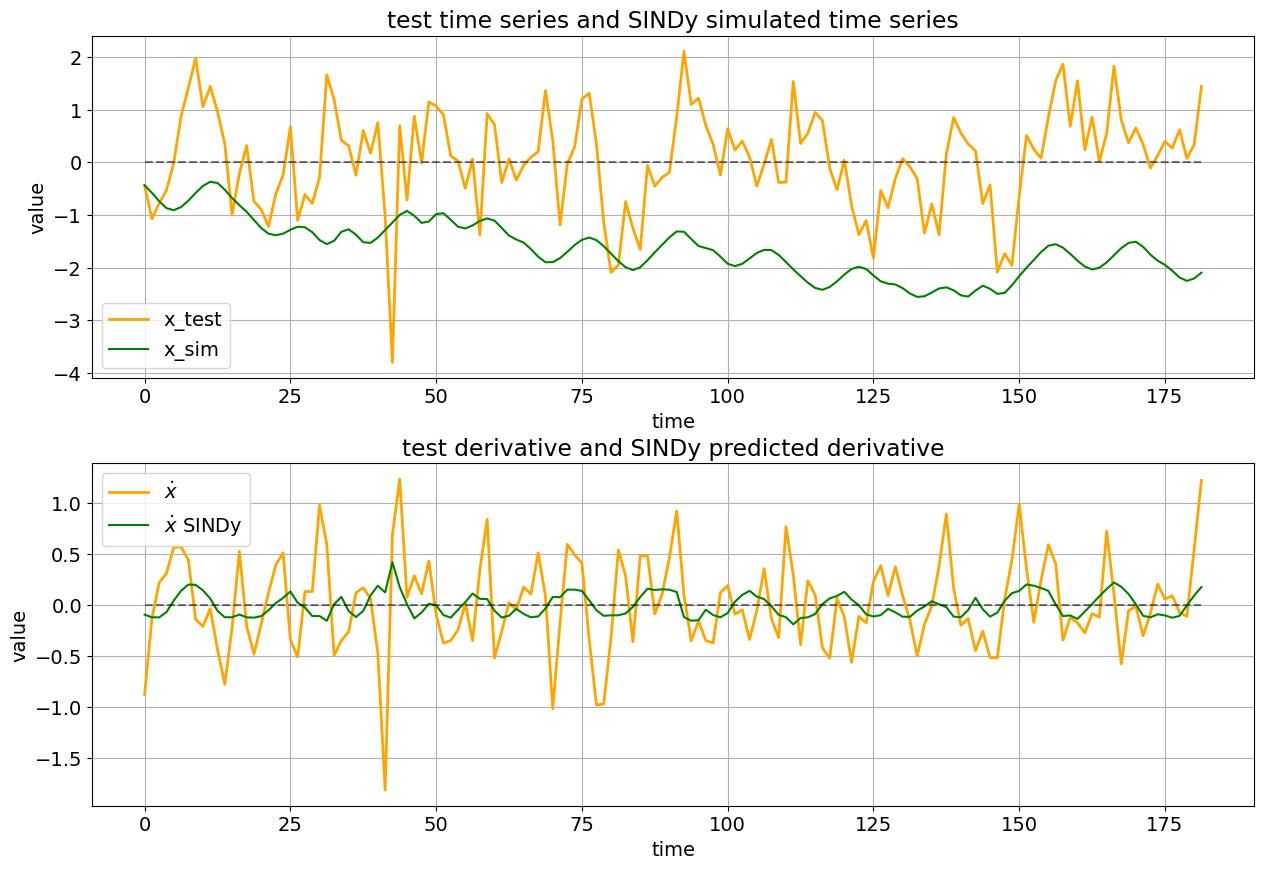

In [6]:
# plot check
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.25
)

ax = axs[0]
ax.plot(t_test, x_test, c='orange', linestyle='-', label='x_test', **plot_kws)
ax.plot(t_test, x_sim, c='green', linestyle='-', label='x_sim')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('test time series and SINDy simulated time series')
ax.legend()

ax = axs[1]
ax.plot(t_test, x_dif, c='orange', linestyle='-', label='$\dot{x}$', **plot_kws)
ax.plot(t_test, x_dot, c='green', linestyle='-', label='$\dot{x}$ SINDy')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('test derivative and SINDy predicted derivative')
ax.legend()

```
modeling the stimulus:
```
$$\dot{u} = f(u)$$

## SINDy on stimulus signal

In [7]:
df = data_df[data_df['pid'] == '001'][data_df['block'] == 1]
df = df.reset_index()

### time-delay coordinates

`time-delay coordinates`
```python
model = ps.SINDy(
    optimizer=ps.STLSQ(0.01),
    feature_library=ps.PolynomialLibrary(degree=10),
    differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=4),
    feature_names=['u0', 'u1'],
    discrete_time=False
)

(u0)' = -0.011 u0 + -0.393 u1
(u1)' = 0.404 u0
```

(u0)' = -0.011 u0 + -0.393 u1
(u1)' = 0.404 u0


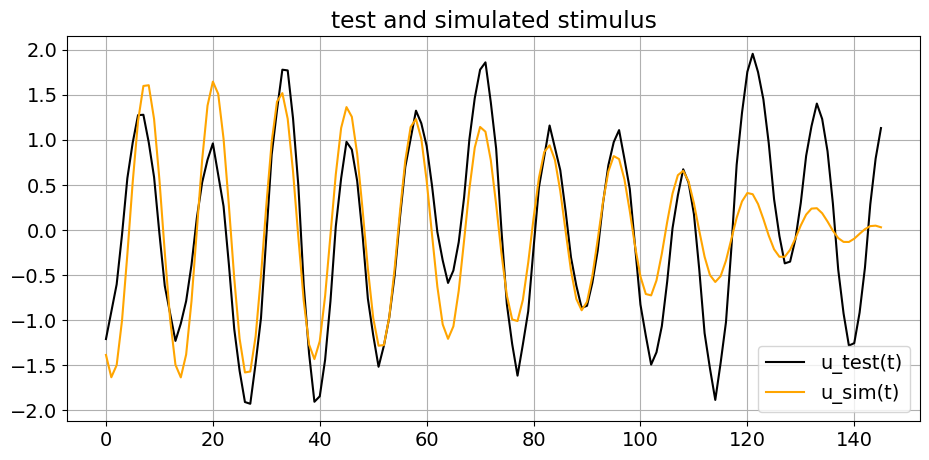

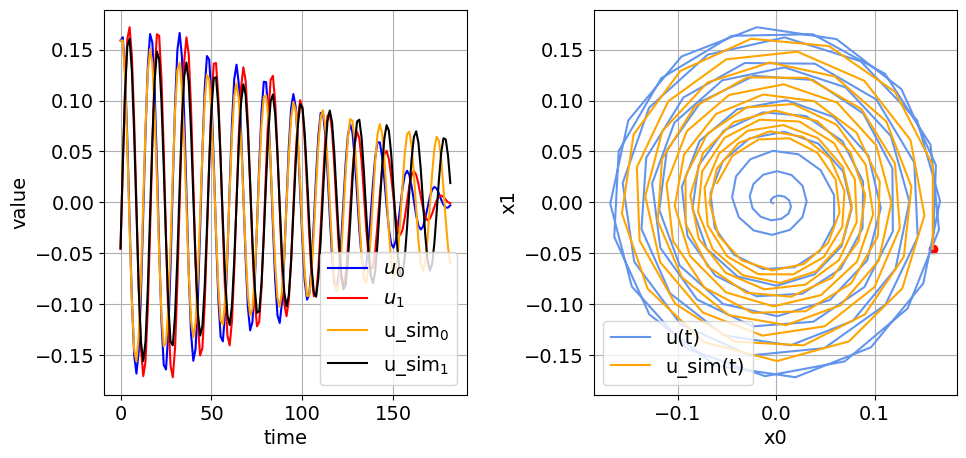

In [8]:
args.num_coords = 2 #np.argmin(np.diff(S))
x = []
for idx, row in df.iterrows():
    if idx != 0: continue
    n = row['proximity'].shape[0] // 1
    # Hankel matrix
    H = sp.linalg.hankel(row['proximity'])[np.ix_(np.arange(0, n), np.arange(0, n))]
    U, S, Vh = np.linalg.svd(H)
    S = np.diag(S)
    # eigen timeseries 
    x.append(
        Vh[:args.num_coords, :].T
    )

model = ps.SINDy(
    optimizer=ps.STLSQ(0.01),
    feature_library=ps.PolynomialLibrary(degree=10),
    differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=4),
    feature_names=['u0', 'u1'],
    discrete_time=False
)
model.fit(
    x=x[0],
    t=1.25,
    multiple_trajectories=False,
    library_ensemble=False,
    ensemble=False
)
model.print()
x_test = x[0]
t_test = np.arange(0, 1.25*len(x_test), 1.25) # len(x_test)
x_sim = model.simulate(
    x0=x_test[0],
    t=t_test,
)
x_rec = (
    U[:, :args.num_coords] @
    S[np.ix_(np.arange(0, args.num_coords), np.arange(0, args.num_coords))] @
    x_sim.T
)[:, 0]

fig, axs = plt.subplots(1, 1, figsize=(11, 5))
ax = axs
ax.plot(df.iloc[0]['proximity'][:len(x_rec)], c='k', label='u_test(t)')
ax.plot(x_rec, c='orange', label='u_sim(t)')
ax.set(
    title='test and simulated stimulus'
)
ax.legend()
ax.grid(True)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=0.35, hspace=0.25
)
ax = axs[0]
ax.plot(t_test, x_test[:, 0], c='blue', label='$u_0$')
ax.plot(t_test, x_test[:, 1], c='red', label='$u_1$')
ax.plot(t_test, x_sim[:, 0], c='orange', label='u_sim$_0$')
ax.plot(t_test, x_sim[:, 1], c='black', label='u_sim$_1$')
ax.set(xlabel='time', ylabel='value')
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(x_test[:, 0], x_test[:, 1], c='cornflowerblue', label='u(t)')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='orange', label='u_sim(t)')
ax.scatter(x_sim[0,0], x_sim[0, 1], c='r')
ax.set(xlabel='x0', ylabel='x1')
ax.grid(True)
ax.legend()

```
issues: 
- the simulated signals decay with time. 
- the oscillations also do not match those in the test signal.
```
```
==technical question==:
how do we map back the simulated signals from time-delay coordinates to the 1D space?
we map the 1D time series `x_train` onto time-delay coordinates using SVD of Hankel matrix. 
```
$U S V^* = H$
```
and use columns of `V` as time-delay coords. we can map back from time-delay coords to 1D space the simulated signals for `x_train` by reverting the SVD process. 
but how do we do so for another signal, say `x_test`? 
```

### 2D ODE

#### typical 2D system

```
2D ODE.
maybe 1D dynamical system cannot generate oscillations (observed in the stimulus). 
try modeling a second order system. 
```
$$ 
\frac{d}{dt} \begin{bmatrix} u \\ \dot{u} \end{bmatrix} = f \left( \begin{bmatrix} u \\ \dot{u} \end{bmatrix} \right) 
$$

```python
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.002, normalize_columns=True),
    feature_library=ps.PolynomialLibrary(degree=2),
    differentiation_method=ps.FiniteDifference(),
    feature_names=['u0', 'u1'],
)
```
```
(u0)' = 1.000 u1
(u1)' = 0.002 1 + -0.124 u0 + -0.002 u1 + 0.002 u0^2 + 0.015 u0 u1 + -0.037 u1^2
```

(u0)' = 1.000 u1
(u1)' = 0.002 1 + -0.124 u0 + -0.002 u1 + 0.002 u0^2 + 0.015 u0 u1 + -0.037 u1^2


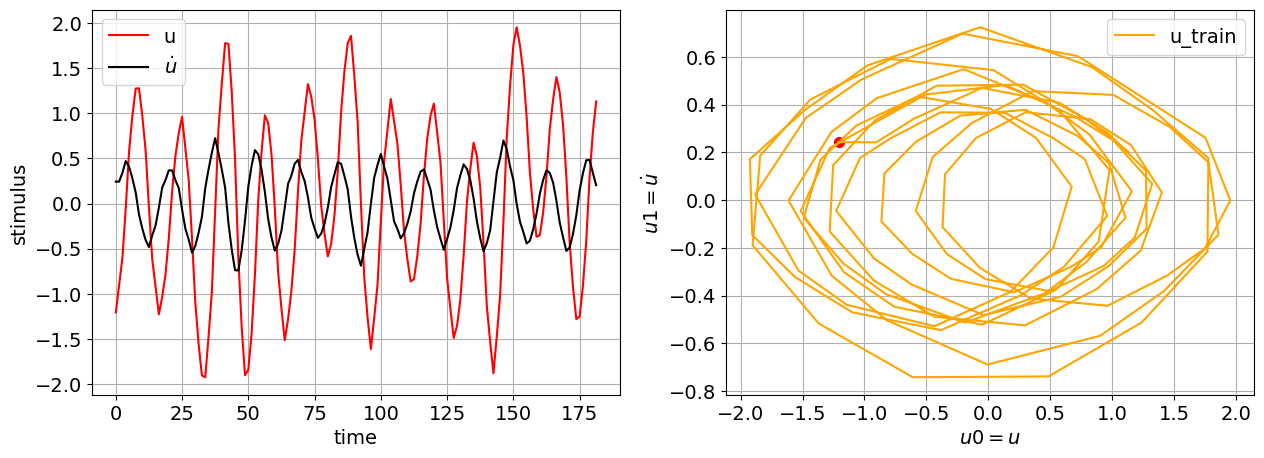

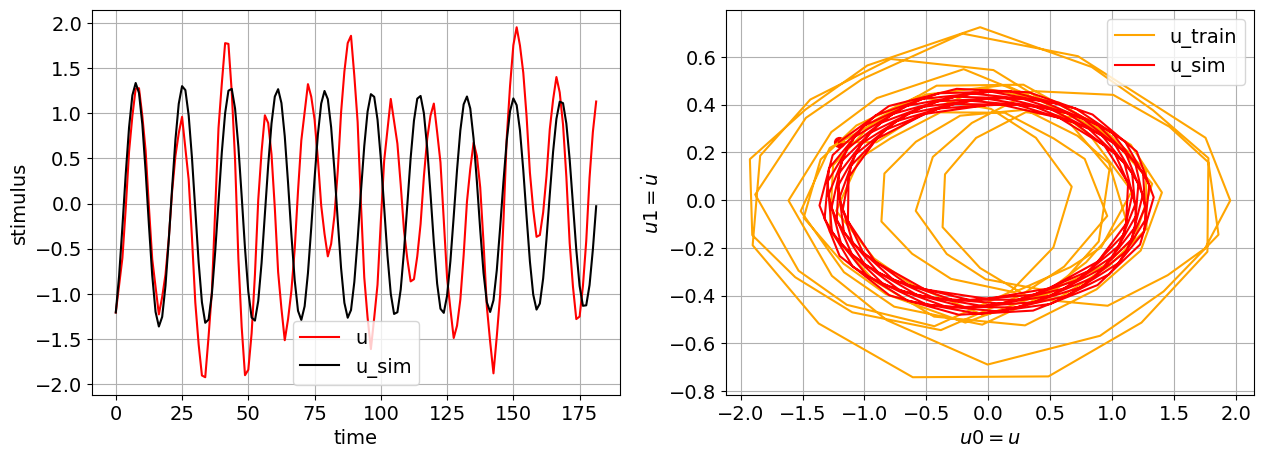

In [9]:
row = df.iloc[0]
t = row['time']
x0 = row['proximity']
differentiation_method = ps.FiniteDifference()
x1 = differentiation_method._differentiate(x0, t)
dt = np.diff(t)[0]
x0_ = np.concatenate(([x0[0]], x0[0] + np.cumsum(x1)[:-1]*dt))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.plot(t, x0, 'r-', label='u')
# ax.plot(t, x0_, 'g-', label='$\int{\dot{u}}$')
ax.plot(t, x1, 'k-', label='$\dot{u}$')
ax.legend()
ax.grid(True)
ax.set(xlabel='time', ylabel='stimulus')

ax = axs[1]
ax.plot(x0, x1, c='orange', label='u_train')
ax.set(xlabel='$u0 = u$', ylabel='$u1 = \dot{u}$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)
ax.legend()

x_train = np.stack([x0, x1], axis=-1)

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.002, normalize_columns=True),
    feature_library=ps.PolynomialLibrary(degree=2),
    differentiation_method=ps.FiniteDifference(),
    feature_names=['u0', 'u1'],
)
model.fit(x=x_train, t=dt)
model.print()

x_sim = model.simulate(x_train[0], t)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
ax.plot(t, x_train[:, 0], 'r-', label='u')
ax.plot(t, x_sim[:, 0], 'k-', label='u_sim')
ax.set(xlabel='time', ylabel='stimulus')
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(x_train[:, 0], x_train[:, 1], c='orange', label='u_train')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='red', label='u_sim')
ax.set(xlabel='$u0 = u$', ylabel='$u1 = \dot{u}$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)
ax.legend()

```
clearly there is not fit.
```

#### SINDyPI formulation

```python
library_functions = [
    lambda u: u,
    lambda u: u*u,
]
library = ps.PDELibrary(
    library_functions=library_functions,
    temporal_grid=t,
    function_names=library_function_names,
    include_bias=True,
    implicit_terms=True,
    derivative_order=2,
).fit(x)

optimizer = ps.SINDyPI(
    threshold=0.1,
    tol=1e-5,
    thresholder="l1",
    max_iter=6000,
    # normalize_columns=True
)

model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library,
    feature_names=['u'],
)
```
```
u_tt = -0.003 1 + -0.075 u + -0.001 u^2 + 0.006 uu_t + -0.001 u^2u_t + 0.230 u^2u_tt
```
$\implies$
$$ 
\frac{d}{dt} \begin{bmatrix} u \\ \dot{u} \end{bmatrix} = 
\begin{bmatrix} 
\dot{u} \\  
\frac{-0.075 u}{1 - 0.23 u^2}
\end{bmatrix} 
$$

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
1 = -0.031 u + 0.472 u^2 + 0.086 u_t + -0.163 u_tt + 0.006 uu_t + -0.008 u^2u_t + -0.320 uu_tt + -0.151 u^2u_tt
u = -0.025 1 + -0.094 u^2 + -0.004 u_t + -2.992 u_tt + 0.153 uu_t + 0.014 u^2u_t + -0.942 uu_tt + -1.055 u^2u_tt
u^2 = 0.409 1 + -0.127 u + -0.052 u_t + 0.008 u_tt + 0.155 u^2u_t + -4.431 uu_tt + -0.478 u^2u_tt
u_t = 0.013 1 + -0.005 u^2 + 0.010 uu_t + 0.689 u^2u_t + -0.003 uu_tt
u_tt = -0.003 1 + -0.075 u + -0.001 u^2 + 0.006 uu_t + -0.001 u^2u_t + 0.230 u^2u_tt
uu_t = 0.031 u + -0.002 u^2 + 0.009 u_t + 0.059 u_tt + -0.088 u^2u_t + 0.064 u^2u_tt
u^2u_t = -0.001 1 + 0.003 u + 0.020 u^2 + 0.614 u_t + -0.076 uu_t + 0.148 uu_tt + 0.018 u^2u_tt
uu_tt = -0.008 1 + -0.034 u + -0.124 u^2 + 0.026 u^2u_t + -0.151 u^2u_tt
u^2u_tt = -0.011 1 + -0.117 u + -0.039 u^2 + 1.024 u_tt + 0.027 uu_t + 0.014 u^2u_t + -0.468 uu_tt


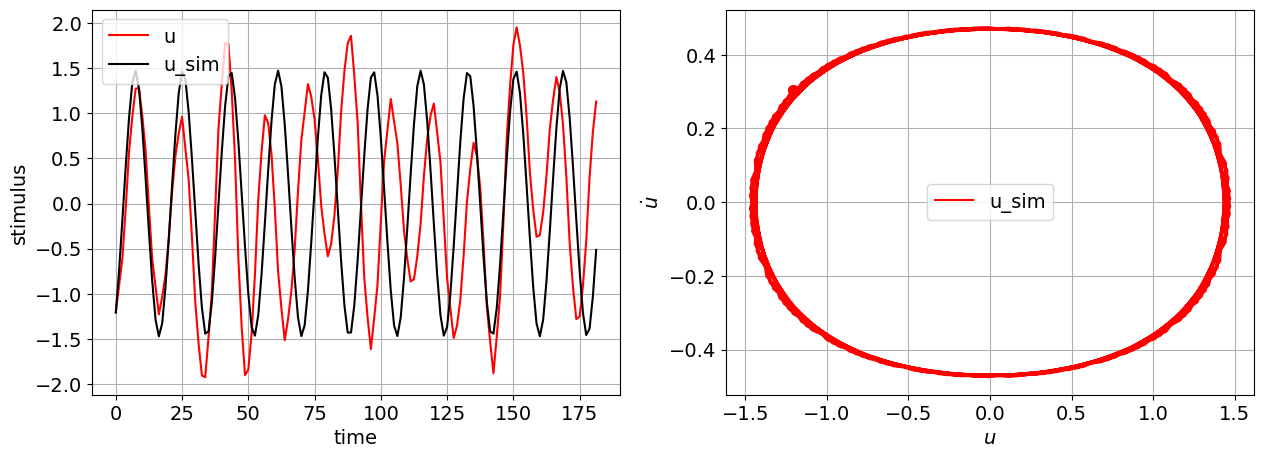

In [10]:
row = df.iloc[0]
t = row['time']
x = row['proximity']
x = np.reshape(x, (x.shape[0], 1))
x = [x]

# custom library
library_functions = [
    lambda u: u,
    lambda u: u*u,
]
library_function_names = [
    lambda u: u,
    lambda u: u+"^2",
]
library = ps.PDELibrary(
    library_functions=library_functions,
    temporal_grid=t,
    function_names=library_function_names,
    include_bias=True,
    implicit_terms=True,
    derivative_order=2,
).fit(x)
library.transform(x)
# print(library.get_feature_names())

optimizer = ps.SINDyPI(
    threshold=0.1,
    tol=1e-5,
    thresholder="l1",
    max_iter=6000,
    # normalize_columns=True
)

model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library,
    feature_names=['u'],
)
model.fit(x, t, multiple_trajectories=True)
model.print()


def fun(t, x):
    return [x[1], (-0.075 * x[0]) / (1 - 0.23*x[0]**2)]
x0 = x


x_sim = sp.integrate.solve_ivp(
    fun, (t[0], t[-1]), [x[0][0,0], np.diff(x[0], axis=0)[0, 0]], t_eval=t, **integrator_keywords
).y.T

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
ax.plot(t, x[0][:, 0], 'r-', label='u')
ax.plot(t, x_sim[:, 0], 'k-', label='u_sim')
ax.set(xlabel='time', ylabel='stimulus')
ax.legend()
ax.grid(True)

ax = axs[1]
# ax.plot(x[0][:, 0], x[0][:, 1], c='orange', label='x_train')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='red', label='u_sim')
ax.set(xlabel='$u$', ylabel='$\dot{u}$')
ax.scatter(x_sim[0, 0], x_sim[0, 1], s=50, c='r')
ax.legend()
ax.grid(True)